Facial emotions are universal way of interaction. In this notebook, we look at various CNN architectures to classify 7 different types of emotions. The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

The training set consists of 28,709 examples. The public test set used for the leaderboard consists of 3,589 examples.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


Emotion column mapping is as follows:

(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)

In [ ]:
samples_per_class = []

for cls in range(7):
    samples_per_class.append(len(train_data[train_data['emotion'] == cls]))

In [ ]:
samples_per_class

[3995, 436, 4097, 7215, 4830, 3171, 4965]

Text(0, 0.5, 'No. of samples')

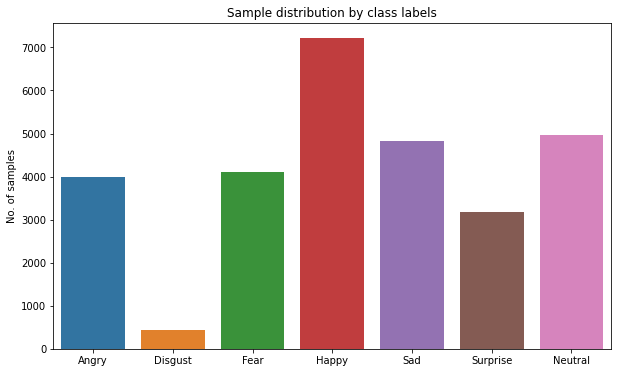

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the width and height of the figure
plt.figure(figsize=(10,6))

x_data = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Add title
plt.title("Sample distribution by class labels")

# Bar chart sample distribution in the dataset.
sns.barplot(x=x_data, y=samples_per_class)

# Add label for vertical axis
plt.ylabel("No. of samples")

In [ ]:
test_data = pd.read_csv(test_data_path)
test_data.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [ ]:
data_path = "/content/drive/MyDrive/data/icml_face_data.csv"

data = pd.read_csv(data_path)

In [ ]:
data[" Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [ ]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data.columns = data.columns.str.replace(" ","")

In [ ]:
len(data[(data['Usage'] == "Training") & (data["emotion"] == 1)])

436

In [ ]:
def get_label_counts(usage,emotion):
  return len(data[(data['Usage'] == usage) & (data["emotion"] == emotion)])

In [ ]:
usages = ["Training","PublicTest"]

train_label_count = {}
test_label_count = {}

for usage in usages:
  for label in range(7):
    if usage == "Training":
      train_label_count[label] = get_label_counts(usage,label)
    else:
      test_label_count[label] = get_label_counts(usage,label)


In [ ]:
import math

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

In [ ]:
class_weights = create_class_weight(train_label_count)
class_weights

{0: 1.0, 1: 2.290203713204264, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}

In [ ]:
X_train,train_y,X_test,test_y = [],[],[],[]

In [ ]:
for index,row in data.iterrows():
    pixels = row["pixels"].split(" ")
        
    if "Training" in row["Usage"]:
        X_train.append(np.array(pixels,'float32'))
        train_y.append(row['emotion'])
    elif "PublicTest" in row["Usage"]:
        X_test.append(np.array(pixels,'float32'))
        test_y.append(row['emotion'])

        

In [ ]:
X_train = np.array(X_train, 'float32')
train_y = np.array(train_y, 'float32')
X_test = np.array(X_test, 'float32')
test_y = np.array(test_y, 'float32')

In [ ]:
#Standardize the pixel values

X_train/=255.0
X_test/=255.0

In [ ]:
from sklearn.preprocessing import LabelEncoder

n_classes = 7

le = LabelEncoder()
y_train = le.fit_transform(train_y)
y_test = le.transform(test_y)
y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

In [ ]:
# Prepare the training dataset.
batch_size = 256

#input_shape = [-1,48,48,3]

train_inputs=tf.convert_to_tensor(X_train)
#train_inputs = tf.reshape(train_inputs,input_shape)

train_outputs = tf.convert_to_tensor(y_train)

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_outputs))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [ ]:
train_inputs

<tf.Tensor: shape=(28709, 2304), dtype=float32, numpy=
array([[ 70.,  80.,  82., ..., 106., 109.,  82.],
       [151., 150., 147., ..., 193., 183., 184.],
       [231., 212., 156., ...,  88., 110., 152.],
       ...,
       [ 74.,  81.,  87., ..., 188., 187., 187.],
       [222., 227., 203., ..., 136., 136., 134.],
       [195., 199., 205., ...,   6.,  15.,  38.]], dtype=float32)>

In [ ]:
test_inputs = tf.convert_to_tensor(X_test)
#test_inputs = tf.reshape(test_inputs,input_shape)
test_outputs = tf.convert_to_tensor(y_test)

In [ ]:
import sys

#Append the path to DL models
sys.path.insert(0,'../models/')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Model 1 : Basic CNN

from CNN_v2 import CNNV2

cnn = CNNV2(48,7)
cnn

In [ ]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
%%time

history = cnn.fit(train_inputs,train_outputs,
                  batch_size=batch_size, epochs=10,
                  validation_data=(test_inputs, test_outputs))

Epoch 1/10
113/113 [==============================] - 58s 504ms/step - loss: 1.8335 - accuracy: 0.2452 - val_loss: 1.8044 - val_accuracy: 0.2494
Epoch 2/10
113/113 [==============================] - 66s 587ms/step - loss: 1.7956 - accuracy: 0.2559 - val_loss: 1.7807 - val_accuracy: 0.2680
Epoch 3/10
113/113 [==============================] - 71s 630ms/step - loss: 1.7699 - accuracy: 0.2745 - val_loss: 1.7483 - val_accuracy: 0.2862
Epoch 4/10
113/113 [==============================] - 72s 639ms/step - loss: 1.7376 - accuracy: 0.3039 - val_loss: 1.7196 - val_accuracy: 0.3324
Epoch 5/10
113/113 [==============================] - 78s 694ms/step - loss: 1.7048 - accuracy: 0.3323 - val_loss: 1.6835 - val_accuracy: 0.3558
Epoch 6/10
113/113 [==============================] - 89s 791ms/step - loss: 1.6728 - accuracy: 0.3550 - val_loss: 1.6520 - val_accuracy: 0.3736
Epoch 7/10
113/113 [==============================] - 88s 777ms/step - loss: 1.6449 - accuracy: 0.3719 - val_loss: 1.6295 - val_ac

In [ ]:
# Model 2 : SqueezeNet

IMAGE_SIZE = [48,48]

bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 1]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(7, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 48, 48, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_17 (Conv2D)             (None, 48, 48, 24)   792         ['batch_normalization_16[0]

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)]

In [ ]:
EPOCHS = 50

In [ ]:
model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
input_shape = [-1,48,48,1]

In [ ]:
train_inputs = tf.reshape(train_inputs,input_shape)

In [ ]:
test_inputs = tf.reshape(test_inputs,input_shape)

In [ ]:
%%time

history = model.fit(train_inputs,train_outputs,
                  batch_size=batch_size, epochs=EPOCHS,
                  validation_data=(test_inputs, test_outputs),
                  callbacks = callbacks)


Epoch 1/50
113/113 [==============================] - 415s 4s/step - loss: 1.7666 - accuracy: 0.3089 - val_loss: 2.0355 - val_accuracy: 0.2909 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - 415s 4s/step - loss: 1.4580 - accuracy: 0.4418 - val_loss: 1.6519 - val_accuracy: 0.3697 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - 409s 4s/step - loss: 1.3010 - accuracy: 0.5055 - val_loss: 1.4497 - val_accuracy: 0.4528 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - 412s 4s/step - loss: 1.1993 - accuracy: 0.5471 - val_loss: 1.3326 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 5/50
113/113 [==============================] - 410s 4s/step - loss: 1.1217 - accuracy: 0.5754 - val_loss: 1.4148 - val_accuracy: 0.4798 - lr: 0.0010
Epoch 6/50
113/113 [==============================] - 406s 4s/step - loss: 1.0489 - accuracy: 0.6058 - val_loss: 1.2884 - val_accuracy: 0.5093 - lr: 0.0010
Epoch 7/50
113/113 [==============================] - 407s 4s/st

KeyboardInterrupt: ignored

In [ ]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

The model clearly seems to be overfitting. One of the main reasons for overfitting is that your model is too complex for our problem. SO lets try reducing the fire modules in the squeezenet model and see if are getting any improvement.

In [ ]:
IMAGE_SIZE = [48,48]
x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 1]) # input is 48x48 pixels grayscale

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=0.9)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Flatten()(y)
y = tf.keras.layers.Dense(1024,activation="relu")(y)
y = tf.keras.layers.Dropout(0.3)(y)
y = tf.keras.layers.BatchNormalization(momentum=0.9)(y)
y = tf.keras.layers.Dense(7, activation='softmax')(y)

model = tf.keras.Model(x, y)

In [ ]:
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

sgd = tf.keras.optimizers.SGD(learning_rate=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 48, 48, 32)   0           ['batch_normalization[0][0]']

In [ ]:
EPOCHS = 35
BATCH_SIZE = 256

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2,width_shift_range=0.1,
                            height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [ ]:
train_datagen.flow(train_inputs,train_outputs,batch_size=32)

In [ ]:
train_generator = train_datagen.flow(train_inputs,train_outputs,batch_size=128)

In [ ]:
list(train_generator)

In [ ]:
test_generator = test_datagen.flow(test_inputs,test_outputs,batch_size=64)

In [ ]:
EPOCHS = 100

In [ ]:
%%time

history = model.fit(train_generator,
                  epochs=EPOCHS,
                  validation_data=test_generator,
                  callbacks = callbacks)

Epoch 1/25
225/225 [==============================] - 410s 2s/step - loss: 2.0288 - accuracy: 0.2309 - val_loss: 1.8392 - val_accuracy: 0.2591 - lr: 0.0010
Epoch 2/25
 86/225 [==========>...................] - ETA: 4:04 - loss: 1.8720 - accuracy: 0.2692

KeyboardInterrupt: ignored

In [ ]:
class CNNV2(tf.keras.Model):

    def __init__(self,input_dim,output_size):
        super().__init__()
        self.input_dim = input_dim
        self.output_size = output_size
        
        self.input_size = [-1,self.input_dim,self.input_dim,1]
        
        #1st layer
        #Param 1: Number of filters
        #Param 2 = Kernel matrix size
        self.conv1 = tf.keras.layers.Conv2D(32,5,padding = 'same',activation='relu',name='conv1',
                    input_shape = self.input_size ,data_format='channels_last')
        
        
        #Max pool layer 1
        self.maxpool1 = tf.keras.layers.MaxPool2D(strides=(2,2),name='pool1')
        
        #2nd layer with 64 filters
        self.conv2 = tf.keras.layers.Conv2D(64,5,padding = 'same',activation='relu',name='conv2'
        )
        
        #Max pool layer 2
        self.maxpool2 = tf.keras.layers.MaxPool2D(strides=2,name='pool2')

        #3rd layer with 64 filters
        self.conv3 = tf.keras.layers.Conv2D(64,5,padding = 'same',activation='relu',name='conv3'
        )
        
        #Max pool layer 3
        self.maxpool3 = tf.keras.layers.MaxPool2D(strides=2,name='pool3')

        #Final Convolution layer
        self.conv4 = tf.keras.layers.Conv2D(32,5,padding = 'same',activation='relu',name='conv4'
        )
        
        #Max pool layer 4
        self.maxpool4 = tf.keras.layers.MaxPool2D(strides=2,name='pool4')

        #Dense fully connected layer
        self.dense = tf.keras.layers.Dense(
            1024, activation='relu', name='dense')
        
        #Apply dropout during training to avoid co-adaptation
        self.dropout = tf.keras.layers.Dropout(rate=0.4)
        
        #Activation function will be applied to this to get predictions
        self.logits = tf.keras.layers.Dense(self.output_size,name='logits')
        
        
    def call(self,inputs,training=False):
    
        #Forward run of the model
        
        
        reshaped_inputs = tf.reshape(inputs,self.input_size)

        conv1 = self.conv1(reshaped_inputs)

        maxpool1 = self.maxpool1(conv1)

        conv2 = self.conv2(maxpool1)

        maxpool2 = self.maxpool2(conv2)

        conv3 = self.conv3(maxpool2)

        maxpool3 = self.maxpool3(conv3)

        conv4 = self.conv4(maxpool3)

        maxpool4 = self.maxpool4(conv4)

        #Calculate height width channels from maxpool4 layer
        #This is required for creating the fully connected layer
        hwc = maxpool4.shape.as_list()[1:]

        #Calculate the flattened size
        flattened_size = hwc[0] * hwc[1] * hwc[2]

        #Reshape max pool 2 from NHWC format to 2D format
        #First argument batch size is -1 and can take the value required for the reshaping operation
        pool2_flat = tf.reshape(maxpool4, [-1, flattened_size])


        dense = self.dense(pool2_flat)

        if training:
            dropout = self.dropout(dense,training=training)
            logits = self.logits(dropout)
            return tf.nn.softmax(logits)
        else:
            logits = self.logits(dense)
            return tf.nn.softmax(logits)
            #return self.convertLogits(logits)


    def convertLogits(self,logits):
        softmax = tf.nn.softmax(logits,name='softmax')
        prediction = tf.math.argmax(softmax,axis=-1)
        return prediction


In [ ]:
cnn = CNNV2(48,7)

In [ ]:
cnn.compile(optimizer=sgd,
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

sgd = tf.keras.optimizers.SGD(learning_rate=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=(48,48,1)))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(7, activation='softmax',name='fcsoftmax'))


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 48, 48, 1)        4         
 hNormalization)                                                 
                                                                 
 conv1 (Conv2D)              (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 32)      

In [ ]:
%%time

history = model.fit(train_generator,
                  epochs=EPOCHS,
                  validation_data=test_generator,
                  callbacks = callbacks)

Epoch 1/100
225/225 [==============================] - 362s 2s/step - loss: 1.9995 - accuracy: 0.2742 - val_loss: 2.3403 - val_accuracy: 0.1558 - lr: 0.0010
Epoch 2/100
225/225 [==============================] - 359s 2s/step - loss: 1.6745 - accuracy: 0.3553 - val_loss: 1.6344 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 3/100
225/225 [==============================] - 357s 2s/step - loss: 1.5477 - accuracy: 0.4026 - val_loss: 1.3545 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 4/100
225/225 [==============================] - 357s 2s/step - loss: 1.4559 - accuracy: 0.4395 - val_loss: 1.3159 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 5/100
225/225 [==============================] - 356s 2s/step - loss: 1.3902 - accuracy: 0.4668 - val_loss: 1.4445 - val_accuracy: 0.5013 - lr: 0.0010
Epoch 6/100
225/225 [==============================] - 367s 2s/step - loss: 1.3489 - accuracy: 0.4851 - val_loss: 1.2239 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 7/100
225/225 [==============================] - 360